In [8]:
import os
import hdbscan
import debacl
import fastcluster
import sklearn.cluster
import scipy.cluster
import sklearn.datasets
import sklearn.metrics
import sklearn.metrics.cluster
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_palette('Paired', 10)
sns.set_color_codes()

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

   os.environ['OMP_NUM_THREADS'] = '1'

In [9]:
def load_file(filename, className):
  script_dir = os.getcwd()
  data_dir = os.path.join(script_dir, '..', 'data')
  file_path = os.path.join(data_dir, filename)

  try:
    data = pd.read_csv(file_path)
    dataOnly = data.drop(className, axis='columns')
    labelsOnly = data[className]

    encoder = LabelEncoder()

    dict = {'Filename': filename,
        'DataOnly': dataOnly,
        'Data': data,
        'LabelsOnly': encoder.fit_transform(labelsOnly),
        'LabelsEncoded': encoder.classes_,
        'LabelsOnlyEncoded': labelsOnly
        }

    return dict
  except FileNotFoundError:
    print(f"Arquivo {filename} não encontrado no diretório {data_dir}")
    return None
  except pd.errors.EmptyDataError:
    print(f"Arquivo {filename} está vazio")
    return None
  except pd.errors.ParserError:
    print(f"Erro ao analisar o arquivo {filename}")
    return None

In [6]:
data= load_file("iris.csv", "class")
print(data["Filename"])
#print(data["DataOnly"].head())
#print(data["Data"].head())
#print(data["LabelsOnly"].head())
print(data["LabelsEncoded"])


iris.csv
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [15]:
def benchmark_algorithm(dataset, cluster_function_name, cluster_function, function_args, function_kwds, sample_size=2):
    start_time = time.time()
    cluster = cluster_function(dataset["DataOnly"], *function_args, **function_kwds)
    time_taken = time.time() - start_time
    contingency = sklearn.metrics.cluster.contingency_matrix(dataset["LabelsOnly"], cluster.labels_)
    var = []
    for n in contingency:
        var.append(np.where(n == max(n))[0][0])
    clusterLabels = cluster.labels_.copy().astype('object')
    for n in var:
        if(n <= len(dataset["LabelsEncoded"])):
            clusterLabels[clusterLabels==n]=dataset["LabelsEncoded"][n]

    confusion_matrix = sklearn.metrics._classification.confusion_matrix(dataset["LabelsOnly"], cluster.labels_, normalize='all')
    cmd = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=dataset["LabelsEncoded"],)
    
    purity_score = np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)
    jaccard_score = sklearn.metrics._classification.jaccard_score(dataset["LabelsOnly"], cluster.labels_, average='micro')
    adjusted_rand_score = sklearn.metrics.cluster.adjusted_rand_score(dataset["LabelsOnly"], cluster.labels_)
    accuracy_score = sklearn.metrics._classification.accuracy_score(dataset["LabelsOnly"], cluster.labels_)

    classification_report = sklearn.metrics.classification_report(dataset["LabelsOnly"], cluster.labels_, target_names=dataset["LabelsEncoded"], zero_division=0)

    dict = {'ClusterFunctionName': cluster_function_name,
        'Cluster': cluster,
        'TimeTaken': time_taken,
        'ClusterLabels': clusterLabels,
        'AccuracyScore': accuracy_score,
        'PurityScore': purity_score,
        'AdjustedRandScore': adjusted_rand_score,
        'JaccardScore': jaccard_score,
        'ContingencyMatrix': contingency,
        'ConfusionMatrix': confusion_matrix,
        'ClassificationReport': classification_report,
        'ConfusionMatrixDisplay': cmd
        }

    return dict

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Iris Dataset

Cluster Algorithm: K-means
Time Taken (seg): 0.012103557586669922
Accuracy Score: 0.4533333333333333
Purity Score: 0.88
Adjusted Rand Index: 0.7008666982225341
Jaccard Score: 0.29310344827586204
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.19      0.20      0.20        50
 Iris-virginica       0.17      0.16      0.16        50

       accuracy                           0.45       150
      macro avg       0.45      0.45      0.45       150
   weighted avg       0.45      0.45      0.45       150

Cluster Algorithm: DBScan
Time Taken (seg): 0.006000041961669922
Accuracy Score: 0.3333333333333333
Purity Score: 0.3333333333333333
Adjusted Rand Index: 0.0
Jaccard Score: 0.2
                 precision    recall  f1-score   support

    Iris-setosa       0.33      1.00      0.50        50
Iris-versicolor       0.00      0.00      0.00        50
 Iris-virginica       0.00      0.00    

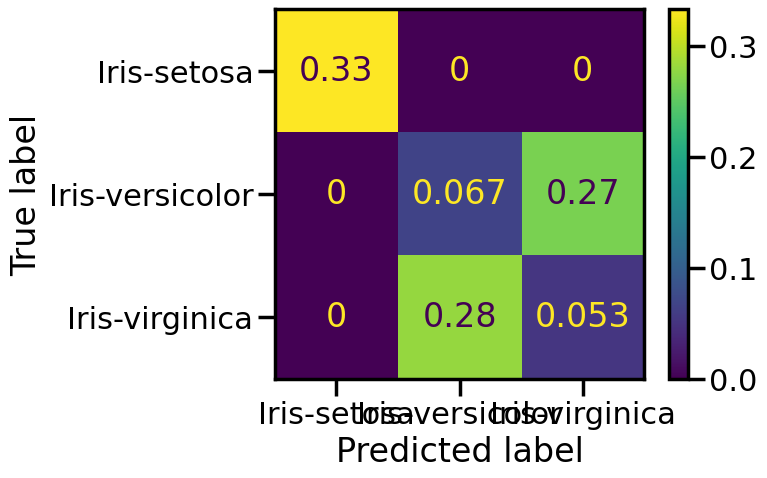

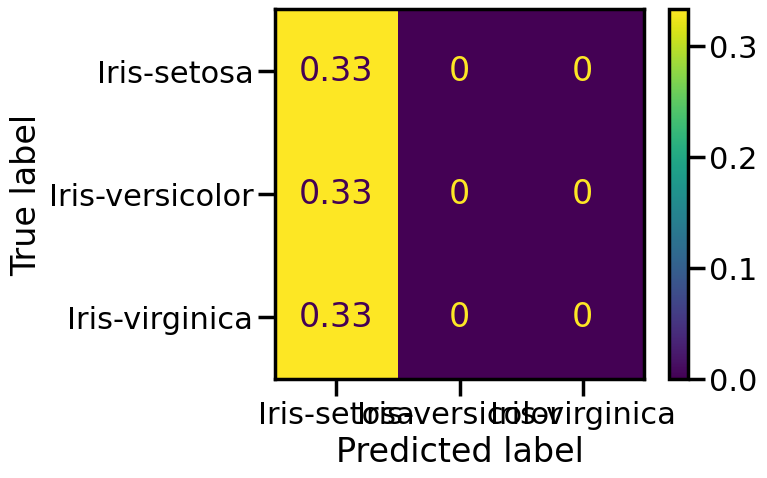

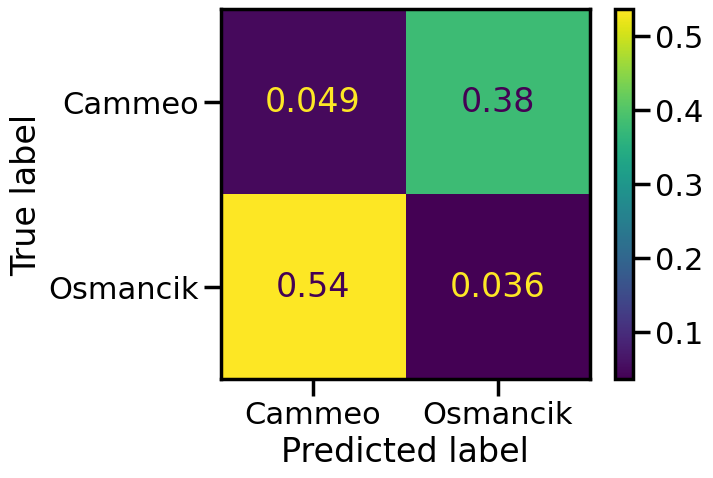

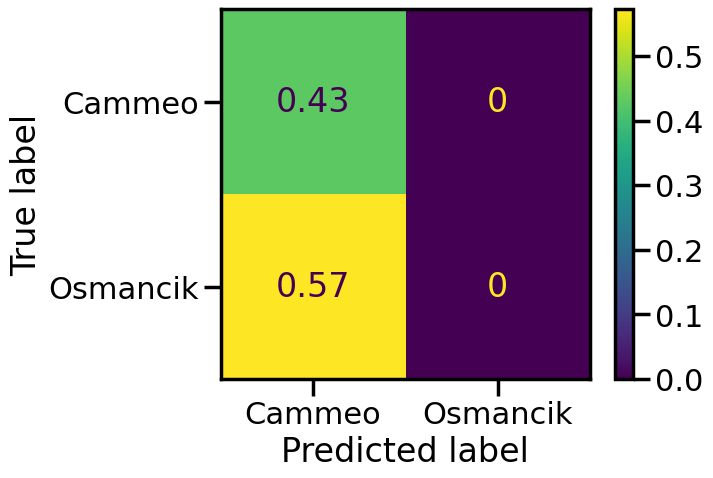

In [21]:
dataList = {
        'Iris': "iris.csv",
        'Rice Cammeo Osmancik': "Rice_Cammeo_Osmancik.arff.csv"
        }

for dataKey in dataList:
    print(color.BOLD + color.UNDERLINE + dataKey + " Dataset" + color.END + "\n")
    
    data = load_file(dataList[dataKey], "class")

    clusterResult = [];

    #'''
    k_means = sklearn.cluster.KMeans(len(data["LabelsEncoded"]), n_init='auto', max_iter=1000) #, random_state=12)
    clusterResult.append(benchmark_algorithm(data, "K-means", k_means.fit, (), {}))
    #'''

    #'''
    dbscan = sklearn.cluster.DBSCAN(eps=1.25)
    clusterResult.append(benchmark_algorithm(data, "DBScan", dbscan.fit, (), {}))
    #'''
    '''
    agglomerative = sklearn.cluster.AgglomerativeClustering(len(data["LabelsEncoded"]))
    clusterResult.append(benchmark_algorithm(data, "Agglomerative Clustering", agglomerative.fit, (), {}))
    #'''
    '''
    spectral = sklearn.cluster.SpectralClustering(len(data["LabelsEncoded"]))
    clusterResult.append(benchmark_algorithm(data, "Spectral Clustering", spectral.fit, (), {}))
    #'''
    '''
    birch = sklearn.cluster.Birch(n_clusters=len(data["LabelsEncoded"]), threshold=0.3)
    clusterResult.append(benchmark_algorithm(data, "Birch", birch.fit, (), {}))
    #'''
    '''
    meanShift = sklearn.cluster.MeanShift()
    clusterResult.append(benchmark_algorithm(data, "Mean Shift", meanShift.fit, (), {}))
    #'''

    #clusterResult.append(benchmark_algorithm(data, "Fast Cluster", fastcluster.linkage_vector, (), {}))
    
    #clusterResult.append(benchmark_algorithm(data, "Hierarchy", scipy.cluster.hierarchy.single, (), {}))    

    '''Não usar
    optics= sklearn.cluster.OPTICS()
    clusterResult.append(benchmark_algorithm(data, "OPTICS", optics.fit, (), {}))
    #'''

    '''Não usar
    affinity_prop = sklearn.cluster.AffinityPropagation(random_state=5)
    clusterResult.append(benchmark_algorithm(data, "Affinity Propagation", affinity_prop.fit, (), {}))
    #'''

    for dataResult in clusterResult:
        print(color.UNDERLINE + "Cluster Algorithm: " + dataResult['ClusterFunctionName'] + color.END)
        print("Time Taken (seg):", dataResult['TimeTaken'])
        print("Accuracy Score:", dataResult['AccuracyScore'])
        print("Purity Score:", dataResult['PurityScore'])
        print("Adjusted Rand Index:", dataResult['AdjustedRandScore'])
        print("Jaccard Score:", dataResult['JaccardScore'])
        #print("Contingency Matrix:", dataResult['ContingencyMatrix'])
        #print("Confusion Matrix:", dataResult['ConfusionMatrix'])
        aaa = dataResult['ConfusionMatrixDisplay']
        dataResult['ConfusionMatrixDisplay'].plot()
        aaa.ax_.set_title("ConfusionMatrix - " dataKey + " - " + dataResult['ClusterFunctionName'])
        print(dataResult['ClassificationReport'])


In [59]:
k_means = sklearn.cluster.KMeans(10)
k_means_data = benchmark_algorithm(dataset_sizes, k_means.fit, (), {})

dbscan = sklearn.cluster.DBSCAN(eps=1.25)
dbscan_data = benchmark_algorithm(dataset_sizes, dbscan.fit, (), {})

scipy_k_means_data = benchmark_algorithm(dataset_sizes,
                                         scipy.cluster.vq.kmeans, (10,), {})

scipy_single_data = benchmark_algorithm(dataset_sizes,
                                        scipy.cluster.hierarchy.single, (), {})

fastclust_data = benchmark_algorithm(dataset_sizes,
                                     fastcluster.linkage_vector, (), {})

hdbscan_ = hdbscan.HDBSCAN()
hdbscan_data = benchmark_algorithm(dataset_sizes, hdbscan_.fit, (), {})

debacl_data = benchmark_algorithm(dataset_sizes,
                                  debacl.geom_tree.geomTree, (5, 5), {'verbose':False})

agglomerative = sklearn.cluster.AgglomerativeClustering(10)
agg_data = benchmark_algorithm(dataset_sizes,
                               agglomerative.fit, (), {}, sample_size=4)

spectral = sklearn.cluster.SpectralClustering(10)
spectral_data = benchmark_algorithm(dataset_sizes,
                                    spectral.fit, (), {}, sample_size=6)

affinity_prop = sklearn.cluster.AffinityPropagation()
ap_data = benchmark_algorithm(dataset_sizes,
                              affinity_prop.fit, (), {}, sample_size=3)

NameError: name 'dataset_sizes' is not defined